# Monte-Carlo方法

## 目录

- [机器学习中的Monte-Carlo](#机器学习中的Monte-Carlo)
- [随机采样介绍](#随机采样介绍)
- [离散分布采样](#离散分布采样)
- [Box-Muller算法](#Box-Muller算法)
- [拒绝采样](#拒绝采样)
- [重要性采样](#重要性采样)
- [MCMC](#MCMC)
    - [Metropolis-Hastings Algorithm](#Metropolis-Hastings-Algorithm)
    - [Gibbs Sampling](#Gibbs-Sampling)

## 机器学习中的Monte-Carlo

来说一下机器学习中Monte-Carlo中用在什么地方：
- 贝叶斯推论和学习：
    - 归一化：$p(x | y) =\frac{p(y | x)p(x)}{\int_Xp(y| x')p(x')dx'}$
    - 边缘概率的计算：$p(x | y) = \int_Z p(x, z | y)dz$
    - 求期望：$E_{p(x|y)}(f(x)) = \int_Xf(x)p(x|y)dx$
    - 上面三处都用到了积分，Monte-Carlo的核心思想即**用样本的和去近似积分**。

## 随机采样介绍

所谓采样，实际上是指根据**某种分布去生成一些数据点**，比如“石头剪刀布”的游戏，服从均匀分布，且概率都是三分之一，采样即希望随机获得一个“石头”或者“剪刀”或者“布”，并且每中情况出现的机会应该是一样的。也就是说，这是我们根据**观察数据再确定分布的过程的逆过程**。

最基本的假设是认为我们可以获得服从**均匀分布**的随机数。一般的采样问题，都可以理解成：**有了均匀分布（简单分布）的采样，如何去获取复杂分布的采样。**

## 离散分布采样

对于**离散的分布**，比如$p(x)=[0.1, 0.5, 0.2, 0.2]^T$，那么我们可以从$u \sim U_{(0,1)}$中采样，把概率分布向量看做一个区间段，然后判断$u$落在哪个区间段内。**区间段的长度和概率成正比，这样采样完全符合原来的分布。**

通过一个例子实现：

假设上面的向量，分别对应“你”，“好”，“合”，“协”四个字分别出现的概率，那么我们随机采样几次，看看出现的结果。

In [1]:
import numpy as np

index2word = ["你","好","合","协"]

def sample_discrete(vec):
    u = np.random.rand()
    start = 0
    for i, num in enumerate(vec):      
        if u > start:
            start += num
        else:
            return i-1
    return i

count = dict([(w, 0) for w in index2word])
# 采样1000次
for i in range(1000):    
    s = sample_discrete([0.1, 0.5, 0.2, 0.2])
    count[index2word[s]] += 1
for k in count:
    print k," : ", count[k]

你  :  110
好  :  493
协  :  216
合  :  181


可以看到采样的频率比较符合设定的概率分布：$[0.1,0.5,0.2,0.2]$

## Box-Muller算法

对于**连续的分布**，如果可以计算这个分布的**累积分布函数（CDF）**，就可以通过计算CDF的**反函数**，结合基础的均匀分布，获得其采样。所以，在这个基础上我们又可以获得一些简单的分布的采样。

**Box-Muller算法**，实现对**高斯分布**的采样。

**原理**:
- 假设随机变量$x,y$都服从标准高斯分布，则有：$f(x,y) = \frac{1}{\sqrt{2\pi}}e^{-x^2/2}\frac{1}{\sqrt{2\pi}}e^{-y^2/2}=\frac{1}{\sqrt{2\pi}}e^{-(x^2+y^2)/2}$。
- 如果使用极坐标系，即$x=rsin(\theta)$，$y=rcos(\theta)$，有$r^2 = x^2+y^2$。
- 求CDF：$P(r\leq R) = \int _{r=0}^R\int_{\theta=0}^{2\pi}\frac{1}{2\pi}e^{r^2}r\;drd\theta=\int_{r=0}^r=e^{-r^2}r\;dr$
- 用$s=\frac{1}{2}r^2$带入，得：$P(r\leq R) = \int _{s=0}^{r^2/2}e^{-s}ds = 1 - e^{-r^2/2}$
- 则，随机采样$\theta$服从均与分布，范围是$0 \leq \theta \leq 1$，可以使$\theta=2\pi U_1$。
- $1-e^{-r^2/2}=1-U_2$即$r=\sqrt{-1ln(U_2)}$

**算法流程**：
- 抽样两个服从均匀分布的随机数：$0 \leq U_1, U_2, \leq 1$。
- 令$\theta = 2\pi U_1$，$r=\sqrt{-2ln(U_2)}$
- $x=rsin(\theta)$，$y=rcos(\theta)$ 都是服从标准高斯分布的变量。

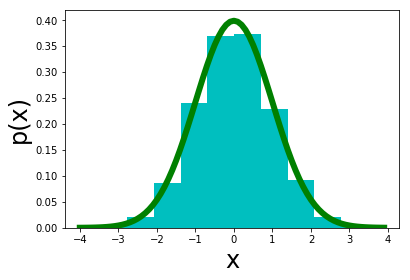

In [2]:
# Code from Chapter 14 of Machine Learning: An Algorithmic Perspective
# by Stephen Marsland (http://seat.massey.ac.nz/personal/s.r.marsland/MLBook.html)

# You are free to use, change, or redistribute the code in any way you wish for
# non-commercial purposes, but please maintain the name of the original author.
# This code comes with no warranty of any kind.

# Stephen Marsland, 2008

# The Box-Muller algorithm for constructing pseudo-random Gaussian-distributed numbers

from pylab import *
import numpy as np

def boxmuller(n):
    
    x = np.zeros((n,2))
    y = np.zeros((n,2))
    
    for i in range(n):
        x[i,:] = np.array([2,2])
        x2 = x[i,0]*x[i,0]+x[i,1]*x[i,1]
        while (x2)>1:
            x[i,:] = np.random.rand(2)*2-1
            x2 = x[i,0]*x[i,0]+x[i,1]*x[i,1]

        y[i,:] = x[i,:] * np.sqrt((-2*log(x2))/x2)
    
    y = np.reshape(y,2*n,1)
    return y

y = boxmuller(1000)
hist(y,normed=1,fc='c')
x = arange(-4,4,0.1)
plot(x,1/np.sqrt(2*np.pi)*np.exp(-0.5*x**2),'g',lw=6)
xlabel('x',fontsize=24)
ylabel('p(x)',fontsize=24)
show()

接下来，我们专注于复杂的任意分布的采样。

## 拒绝采样

拒绝采样（Rejection Sampling）。

假设我们已经可以抽样高斯分布q(x)（如Box–Muller_transform 算法），我们按照一定的方法**拒绝**某些样本，达到接近$p(x)$分布的目的:
![reject](https://github.com/applenob/machine_learning_basic/raw/master/res/rejection_sampling.png)
具体操作：
- 首先，确定常量$k$，使得$p(x)$总在$kq(x)$的下方。
- $x$轴方向：从$q(x)$分布抽样得到$a$。但是$a$并不一定留下，会有一定的几率被**拒绝**。
- $y$轴方向：从均匀分布$(0,kq(a))$中抽样得到$u$。如果$u>p(a)$，也就是落到了灰色的区域中，拒绝，否则接受这次抽样。

拒绝采样实现：

reject count:  17339
Time  0.107921123505


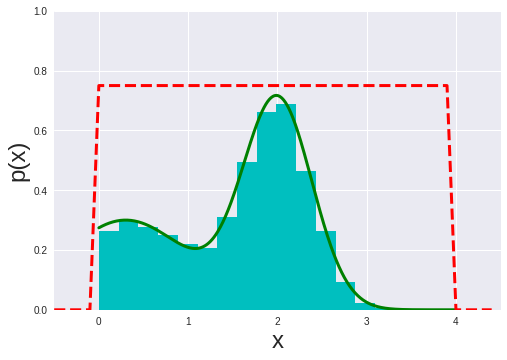

In [3]:
# Code from Chapter 14 of Machine Learning: An Algorithmic Perspective
# The basic rejection sampling algorithm
# 稍有修改，使用matplotlib

%matplotlib inline 
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn

def qsample():
    """使用均匀分布作为q(x)，返回采样"""
    return np.random.rand()*4.

def p(x):
    """目标分布"""
    return 0.3*np.exp(-(x-0.3)**2) + 0.7* np.exp(-(x-2.)**2/0.3) 

def rejection(nsamples):
    
    M = 0.72#0.8 k值
    samples = np.zeros(nsamples,dtype=float)
    count = 0
    for i in range(nsamples):
        accept = False
        while not accept:
            x = qsample()
            u = np.random.rand()*M
            if u<p(x):
                accept = True
                samples[i] = x
            else: 
                count += 1
    print "reject count: ", count   
    return samples

x = np.arange(0,4,0.01)
x2 = np.arange(-0.5,4.5,0.1)
realdata = 0.3*np.exp(-(x-0.3)**2) + 0.7* np.exp(-(x-2.)**2/0.3) 
box = np.ones(len(x2))*0.75#0.8
box[:5] = 0
box[-5:] = 0
plt.plot(x,realdata,'g',lw=3)
plt.plot(x2,box,'r--',lw=3)

import time
t0=time.time()
samples = rejection(10000)
t1=time.time()
print "Time ",t1-t0

plt.hist(samples,15,normed=1,fc='c')
plt.xlabel('x',fontsize=24)
plt.ylabel('p(x)',fontsize=24)
plt.axis([-0.5,4.5,0,1])
plt.show()

在高维的情况下，Rejection Sampling有两个问题：

1. 合适的q分布很难找
2. 很难确定一个合理的k值

导致拒绝率很高。

## 重要性采样

重要性采样（Importance Sampling）。

$E(f)= \int p(x)f(x) dx\\ = \int q(x)\frac{p(x)f(x)}{q(x)} dx$

其中可以把$w(x)=\frac{p(x)}{q(x)}$称为**重要性权重（importance weight）**

**重要性采样算法**：
- 从简单分布$q(x)$中采样N个样本$x^{(i)}$
- 计算归一化的重要性权重：$w^{(i)} = \frac{p(x^{(i)})/q(x^{(i)})}{\sum_j p(x^{(j)})/q(x^{(j)})}$
- 再在分布$\{x^{(i)}\}$中，按照权重$w^{(i)}$作为概率做采样。

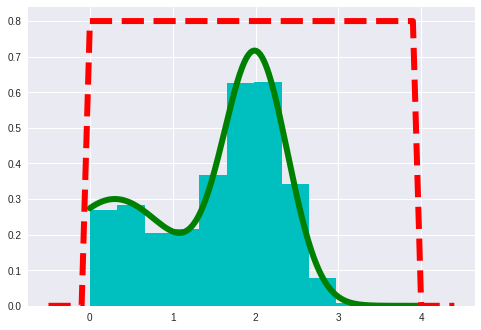

In [14]:
def qsample():
    return np.random.rand()*4.

def p(x):
    return 0.3*np.exp(-(x-0.3)**2) + 0.7* np.exp(-(x-2.)**2/0.3) 

def q(x):
    return 4.0

def importance(nsamples):
    
    samples = np.zeros(nsamples,dtype=float)
    w = np.zeros(nsamples,dtype=float)
    
    for i in range(nsamples):
        samples[i] = qsample()
        w[i] = p(samples[i])/q(samples[i])
                
    return samples, w

def sample_discrete(vec):
    u = np.random.rand()
    start = 0
    for i, num in enumerate(vec):      
        if u > start:
            start += num
        else:
            return i-1
    return i

def importance_sampling(nsamples):
    samples, w = importance(nsamples)
#     print samples
    final_samples = np.zeros(nsamples,dtype=float)
    w = w / w.sum()
#     print w
    for j in range(nsamples):
        final_samples[j] = samples[sample_discrete(w)]
    return final_samples

x = np.arange(0,4,0.01)
x2 = np.arange(-0.5,4.5,0.1)
realdata = 0.3*np.exp(-(x-0.3)**2) + 0.7* np.exp(-(x-2.)**2/0.3) 
box = np.ones(len(x2))*0.8
box[:5] = 0
box[-5:] = 0
plt.plot(x,realdata,'g',lw=6)
plt.plot(x2,box,'r--',lw=6)

# samples,w = importance(5000)
final_samples = importance_sampling(5000)
plt.hist(final_samples,normed=1,fc='c')
plt.show()

可以明显感觉到重要性采样，速度比较慢。

## MCMC

MCMC（Markov Chain Monte Carlo），上面提到的方法都是可以并行的，即某一个样本的产生不依赖于上一个样本的抽样；MCMC是一个链式的抽样过程，即每一个样本抽样跟且只跟上一个样本的抽样相关。

因此我们引入**概率转移矩阵**$T$，即某一时刻是状态$s$，那么下一时刻状态是$s'$的概率是：$T(s,s')$，于是问题变转换成了某一时刻有一个抽样，那么下一个时刻抽样的概率由$T$决定。

另外，不要忘了，不管是从什么状态开始抽样，我们都期望在第$i$次的分布概率$p(x^{(i)})$可以收敛到实际分布$p(x)$。

马尔科夫链若收敛，$T$需要满足
- 不可化简（irreducibility）：即对于x任何可能的取值，都有机会（概率大于0）到达其他的取值（不一定要下一期，只要是在有限的时刻内），即上面的图是闭环的。
- 非周期的（aperiodicity）
- 细致平稳条件（detail balance）$p(x)T(x,x')=p(x')T(x',x)$，保证了chain是reversible。

**关键**：构造转移矩阵$T$，使得平稳分布恰好是我们需要的分布$p(x)$。

### Metropolis-Hastings Algorithm

Metropolis-Hastings的核心思想类似于拒绝采样：我们有一个采样$x^*$，要决定是否留下它。类似的，我们也有一个建议分布$q(x_i|x_{i-1})$。和拒绝采样**不同**的是，**一旦拒绝新的采样，将采样当前的采样作为新采样**。这也是这个算法之所以高效的原因。

算法介绍：对于目标分布$p(x)$，首先给定参考条件概率分布$q(x^*|x)$，然后基于当前x的抽样一个新样本$x^*$，然后依据一定的概率移动到$x^*$（否则还留在$x$），这个概率是接受概率$A(x_i,x^*)=min\{1,\frac{p(x^*)q(x_i|x^*)}{p(x_i)q(x^*|x_i)}\}$

**接受概率的推导**：上面的细致平稳条件：$p(x)T(x,x')=p(x')T(x',x)$，我们希望根据一个建议分布$q$和一个接受率$a$来等价于$T$。即：$p(i)q(i, j)a(i, j) = p(j)q(j,i)a(j,i)$。令$a(j,i)=1$，有$a(i,j)=\frac{p(j)q(j,i)}{p(i)q(j,i)}$。注：这段推导的符号标记和全文的风格不太相同，也比较简洁。

**算法流程**：
- 给顶一个初始值$x_0$
- 重复以下步骤：
    - 从$q(x_i|x_{i-1})$中采样一个样本$x^*$。
    - 从均匀分布中抽样一个$u$。
    - 如果$u<A(x_i,x^*)$
        - $x_{i+1} = x^*$
    - 否则：
        - $x_{i+1} = x_i$
        
接受概率$A(x_i,x^*)$有个形象的比喻：假设你目前在一片高低不平的山地上，**你此行的目的是在海拔越高的地方停留越久**（$p(x)$大的时候，样本里$x$就多）。你的方法是随便指一个新的地方，如果这个地方的海拔更高，那么就移动过去；但如果这个地方的海拔比当前低，你就抛一个不均匀的硬币决定是否过去，而硬币的不均匀程度相当于新海拔和当前海拔的比例。也即新海拔若是当前海拔的一半，你就只有1/2的概率会过去。MH算法中$q(x^*|x_i)$就是按照一定的规律指出一个新方向，$A(x_i,x^*)$就是计算相对高度。

基于上述想法的MH算法实现：

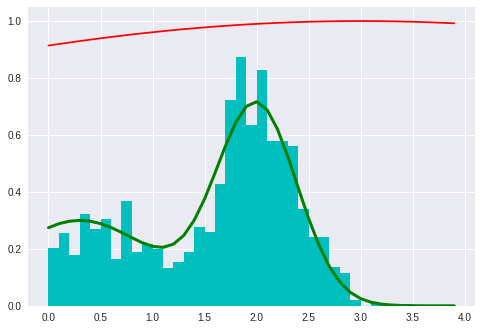

In [15]:
# my own try 
import scipy.stats
mu = 3
sigma = 10
def qsample():
    return np.random.normal(mu,sigma)
def q(x):
    return exp(-(x-mu)**2/(sigma**2))
def p(x):
    """目标分布"""
    return 0.3*np.exp(-(x-0.3)**2) + 0.7* np.exp(-(x-2.)**2/0.3)
def hm(n=10000):
    sample = np.zeros(n)
    sample[0] = 0.5
    for i in range(n-1):
        q_s = qsample()
        u = np.random.rand()
        if u < min(1, (p(q_s)*q(sample[i]))/(p(sample[i])*q(q_s))):
            sample[i+1] = q_s
        else:
            sample[i+1] = sample[i]
    return sample

x = np.arange(0,4,0.1)
realdata = p(x)
N=10000
sample = hm(N)
plt.plot(x,realdata,'g',lw=3)
plt.plot(x,q(x),'r')
plt.hist(sample,bins=x,normed=1,fc='c')
plt.show()

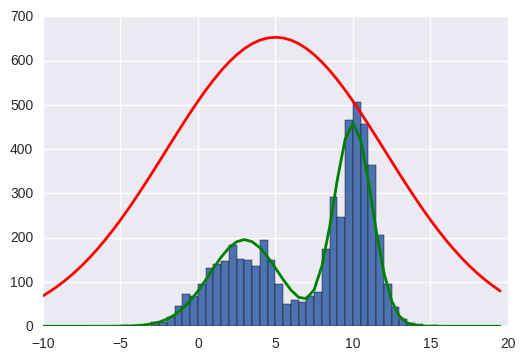

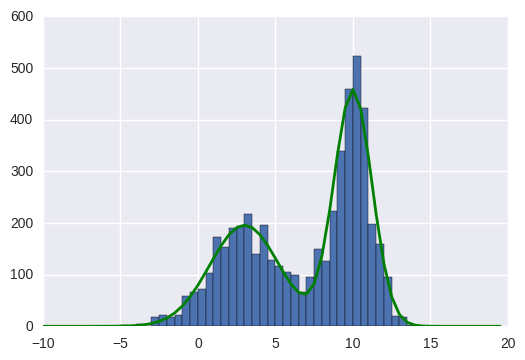

In [31]:
# Code from Chapter 14 of Machine Learning: An Algorithmic Perspective
# by Stephen Marsland (http://seat.massey.ac.nz/personal/s.r.marsland/MLBook.html)

# You are free to use, change, or redistribute the code in any way you wish for
# non-commercial purposes, but please maintain the name of the original author.
# This code comes with no warranty of any kind.

# Stephen Marsland, 2008

# The Metropolis-Hastings algorithm
from pylab import *
from numpy import *

def p(x):
    mu1 = 3
    mu2 = 10
    v1 = 10
    v2 = 3
    return 0.3*exp(-(x-mu1)**2/v1) + 0.7* exp(-(x-mu2)**2/v2)

def q(x):
    mu = 5
    sigma = 10
    return exp(-(x-mu)**2/(sigma**2))

stepsize = 0.5
x = arange(-10,20,stepsize)
px = zeros(shape(x))
for i in range(len(x)):
    px[i] = p(x[i])
N = 5000

# independence chain
u = random.rand(N)
mu = 5
sigma = 10
y = zeros(N)
y[0] = random.normal(mu,sigma)
for i in range(N-1):
    ynew = random.normal(mu,sigma)
    alpha = min(1,p(ynew)*q(y[i])/(p(y[i])*q(ynew)))
    if u[i] < alpha:
        y[i+1] = ynew
    else:
        y[i+1] = y[i]

# random walk chain
u2 = random.rand(N)
sigma = 10
y2 = zeros(N)
y2[0] = random.normal(0,sigma)
for i in range(N-1):
    y2new = y2[i] + random.normal(0,sigma)
    alpha = min(1,p(y2new)/p(y2[i]))
    if u2[i] < alpha:
        y2[i+1] = y2new
    else:
        y2[i+1] = y2[i]

figure(1)
nbins = 30
hist(y, bins = x)
plot(x, px*N/sum(px), color='g', linewidth=2)
plot(x, q(x)*N/sum(px), color='r', linewidth=2)

figure(2)
nbins = 30
hist(y2, bins = x)
plot(x, px*N/sum(px), color='g', linewidth=2)

show()

### Gibbs Sampling

Gibbs Sampling的本质是MH的变种。适用于我们知道完全条件概率的情况，即$p(x_j|x_1,...,x_{j-1},x_{j+1},...,x_n)$，也写作：$p(x_j|x_{-j})$。

采用设置多维概率分布$p$里的**完全条件概率(full conditionals)**作为**建议概率(proposal)，q**，那么接受率就会始终=1，一直接受$x^*$。

对 $j=1,...,n$
$$q(x^*|x^{(i)})= 
\left\{ \begin{matrix} 
p(x^*_j|x^{(i)}_{-j})\;\; if \; x^*_{-j}=x^{(i)}_{-j}\\ 
0 \;\;\;\;\; otherwise 
\end{matrix}\right.$$

**注意**符号的问题，在MH算法中，$x_i$代表第i个样本的值，在Gibbs中，$x_j^{(i)}$代表第i个样本中，第j维（第j个变量）的值。

证明：
$A(x^{(i)},x^*)=min\{1,\frac{p(x^*)q(x^{(i)}|x^*)}{p(x^{(i)})q(x^*|x^{(i)})}\}\\=min\{1,\frac{p(x^*)p(x^{(i)}_j|x^{(i)}_{-j})}{p(x^{(i)})p(x^*_j|x^*_{-j})}\}\\=min\{1,\frac{p(x^*_{-j})}{p(x^{(i)}_{-j})}\}\\=1$

**Gibbs Sampling算法**
- 对每个变量$x_j$：
    - 初始化$x_j^{(0)}$
- 重复：
    - 对每个变量$x_j$：
        - 从$p(x_1 | x_{2}^{(i)}, ... , x_{n}^{(i)})$中采样$x_1^{i+1}$。
        - 从$p(x_2 | x_{1}^{(i+1)}, x_{3}^{(i)}, ..., x_{n}^{(i)})$中采样$x_2^{i+1}$。
        - ...
        - 从$p(x_n | x_{1}^{(i+1)}, ..., x_{n-1}^{(i+1)})$中采样$x_n^{i+1}$。
- 直到有足够多的sample。

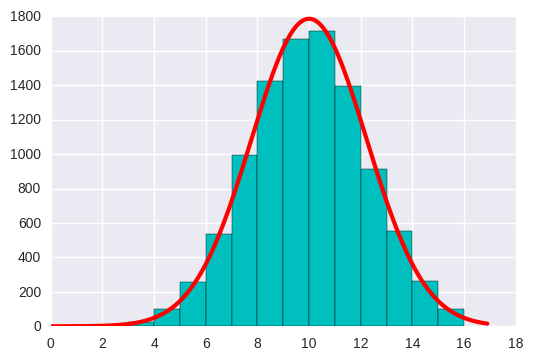

In [6]:
# Code from Chapter 14 of Machine Learning: An Algorithmic Perspective
# A simple Gibbs sampler

def pXgivenY(y,m1,m2,s1,s2):
    return np.random.normal(m1 + (y-m2)/s2,s1)

def pYgivenX(x,m1,m2,s1,s2):
    return np.random.normal(m2 + (x-m1)/s1,s2)

def gibbs(N=5000):
    k=20
    x0 = np.zeros(N,dtype=float)
    m1 = 10
    m2 = 20
    s1 = 2
    s2 = 3
    for i in range(N):
        y = np.random.rand(1)
        # 每次采样需要迭代 k 次
        for j in range(k):
            x = pXgivenY(y,m1,m2,s1,s2)
            y = pYgivenX(x,m1,m2,s1,s2)
        x0[i] = x
    
    return x0

def f(x):
    """目标分布"""
    return np.exp(-(x-10)**2/10)

# 画图
N=10000
s=gibbs(N)
x1 = np.arange(0,17,1)
plt.hist(s,bins=x1,fc='c')
x1 = np.ar
ange(0,17, 0.1)
px1 = np.zeros(len(x1))
for i in range(len(x1)):
    px1[i] = f(x1[i])
plt.plot(x1, px1*N*10/sum(px1), color='r',linewidth=3)

plt.show()

以上算法是简单的二维Gibbs Sampling的实现，如下图：
![](https://raw.githubusercontent.com/applenob/machine_learning_basic/master/res/gibbs2.png)

参考资料：

- [LDA漫游指南](http://yuedu.baidu.com/ebook/d0b441a8ccbff121dd36839a)
- [Machine learning an algorithmic perspective](https://www.amazon.de/Machine-Learning-Algorithmic-Perspective-Recognition/dp/1420067184)
- [An Introduction to MCMC for Machine Learning](http://www.cs.princeton.edu/courses/archive/spr06/cos598C/papers/AndrieuFreitasDoucetJordan2003.pdf)